In [2]:
import cartopy
import os
import numpy as np
import pandas as pd
import tqdm
import xarray as xr
from pykonal.solver import PointSourceSolver
from pykonal.transformations import geo2sph
import covseisnet as csn
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import matplotlib.colors as mcolors
from matplotlib.colors import LightSource
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy import read, read_inventory
from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import mass_downloader
import rasterio
import scipy.interpolate
from glob import glob
import elevation
from osgeo import gdal
import shutil
%pwd

'/Users/brendanmills/Documents/Senior_Thesis/Code'

Set up some variables for where we will put the data

In [3]:
PROJECT_PATH = '/Users/brendanmills/Documents/Senior_Thesis/Data/'
DIRPATH_RAW = PROJECT_PATH + 'Raw/'
DIRPATH_DESTINATION = DIRPATH_RAW #for the mass downloader
os.makedirs(DIRPATH_DESTINATION, exist_ok=True)

## Prepare the data downloader

Here, we define the geographical domain and other restrictions such as data quality and temporal coverage for the data download. 

### Geographical domain
We restrict the data download to the North Anatolian domain using the `RectangularDomain` function.
### Temporal domain and quality restrictions

We restrict the data download to the eight seismic stations on `HH` or `BH` channels with continuous data on 2013-04-23 using the `Restrictions` function.

In [4]:
domain = mass_downloader.RectangularDomain(
    minlatitude=-1,#south
    maxlatitude=-0.5794,#north
    minlongitude=-91.3508,#west
    maxlongitude=-90.9066,#east
)
# grid extent Longitude: 55.67° to 55.81° (145 points), Latitude: -21.3° to -21.2° (110 points)
lon_min = domain.minlongitude
lon_max = domain.maxlongitude
lat_min = domain.minlatitude
lat_max = domain.maxlatitude
t0 = t0 = UTCDateTime("2018-06-26T17:0:00.000")
tdur = 4*3600
restrictions = mass_downloader.Restrictions(
    starttime=t0,
    endtime=t0 + tdur,
    chunklength_in_sec=60*60,
    network="8G",
    location="*",
    channel="*HZ",
    station="SN02,SN04,SN05,SN06,SN07,SN11,SN12,SN13,SN14",
    reject_channels_with_gaps=False,
    minimum_length=0.0,
    minimum_interstation_distance_in_m=1.0,
    channel_priorities=["HH[ZNE]", "BH[ZNE]"],
)

## Download the data

The download can take up to several minutes depending on your internet connection and machine. You may need to run the following cell several times to make sure all data were correctly downloaded; data requests to data centers may fail due to intermittent problems on their servers.

In [6]:
# Downloader instance
downloader = mass_downloader.MassDownloader(providers=['IRIS'])

# Download
downloader.download(
    domain,
    restrictions,
    mseed_storage=DIRPATH_DESTINATION,
    stationxml_storage=DIRPATH_DESTINATION,
)

[2023-02-22 11:41:27,207] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2023-02-22 11:41:27,535] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2023-02-22 11:41:27,538] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2023-02-22 11:41:27,539] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2023-02-22 11:41:27,770] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.23 seconds)
[2023-02-22 11:41:27,771] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 7 stations (7 channels).
[2023-02-22 11:41:27,773] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 7 stations.
[2023-02-22 11:41:27,774] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 28 time intervals/channels before downloading: NEEDS_D

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x102582090>}

## Show inventory

The following shows the locations of the seismic stations that recorded the previously requested data. The inventory contains all metadata related to a given `seed_id`. Please check [this obspy tutorial](https://docs.obspy.org/master/packages/autogen/obspy.core.inventory.inventory.Inventory.plot.html) for more information.

/opt/homebrew/Caskroom/miniforge/base/envs/obspy/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


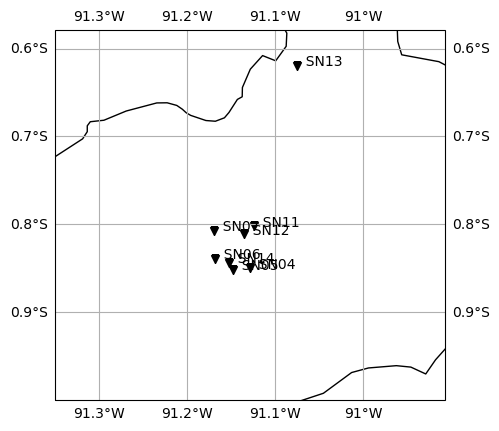

In [5]:
MAP_EXTENT = (
    domain.minlongitude,
    domain.maxlongitude,
    domain.minlatitude,
    domain.maxlatitude,
)

# Read inventory
inventory = read_inventory(os.path.join(DIRPATH_DESTINATION, "*.xml"))

# Create axes
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent(MAP_EXTENT)
ax.gridlines(draw_labels=True)
ax.coastlines()

# Show
for network in inventory:
    for station in network:
        ax.plot(station.longitude, station.latitude, "kv")
        ax.text(station.longitude, station.latitude, "  " + station.code)


# Next Part!
first set some more paths

In [12]:
DIRPATH_RAW = PROJECT_PATH + 'Raw/'
DIRPATH_PROCESSED = PROJECT_PATH + 'Processed/'
# Create directory
os.makedirs(DIRPATH_PROCESSED, exist_ok=True)
print()
# Copy meta to destination
!cp {DIRPATH_RAW}*xml {DIRPATH_PROCESSED}

In [7]:
filepaths_raw = sorted(glob(os.path.join(DIRPATH_RAW, "*.mseed"))) #this gathers a list of the file Paths

1 Trace(s) in Stream:
8G.SN04..HHZ | 2018-06-26T17:00:00.000000Z - 2018-06-26T18:00:01.360000Z | 100.0 Hz, 360137 samples


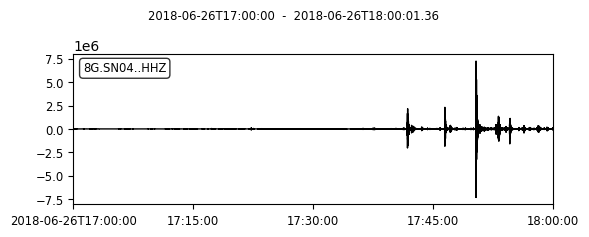

<Figure size 640x480 with 0 Axes>

In [8]:
stream = obspy.read(filepaths_raw[0])
stream.trim(endtime=t0+tdur)
print(stream)
stream.plot(size=(600, 250), show=True)
plt.gcf().set_facecolor('w')

## Preprocess

The next cell loads every waveform and applies the preprocessing workflow, which includes detrending individual segments, filling gaps over the entire day, synchronizing the traces on the requested start and end times, resampling at the target sampling rate and removing the instrument gain. This cell runs in about 3 minutes on a desktop machine.

In [9]:
TARGET_SAMPLING_RATE = 25.0
MAX_SEGMENTS = 10
FREQ_MIN = 2.0
FREQ_MAX = 12.0
TAPER_PERCENT = 0.02
TAPER_TYPE = "cosine"
MSEED_ENCODING = "FLOAT64"
TARGET_STARTTIME = t0
TARGET_ENDTIME = t0+tdur

for filepath_waveform in tqdm.tqdm(filepaths_raw, desc="Processing data"):
    # Read trace
    trace = obspy.read(filepath_waveform)[0]

    # Split trace into segments to process them individually
    stream = trace.split()

    # Apply detrend on segments
    stream.detrend("constant")
    stream.detrend("linear")
    stream.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Merge traces, filling gaps with zeros and imposing start and end times
    stream = stream.merge(fill_value=0.0)
    trace = stream[0]
    trace.trim(starttime=TARGET_STARTTIME, endtime=TARGET_ENDTIME, pad=True, fill_value=0.0)

    # Resample at target sampling rate
    trace.decimate(4)

    # Attach instrument response
    filepath_inventory = f"{trace.stats.network}.{trace.stats.station}.xml"
    filepath_inventory = os.path.join(DIRPATH_RAW, filepath_inventory)
    inventory = obspy.read_inventory(filepath_inventory)
    trace.attach_response(inventory)

    # Remove instrument gain
    trace.remove_sensitivity()

    # Detrend
    trace.detrend("constant")
    trace.detrend("linear")
    trace.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Filter
    trace.filter(
        "bandpass", freqmin=FREQ_MIN, freqmax=FREQ_MAX, zerophase=True
    )
    trace.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Write processed traces
    _, filename = os.path.split(filepath_waveform)
    filepath_processed_waveform = os.path.join(DIRPATH_PROCESSED, filename)
    trace.write(filepath_processed_waveform, encoding=MSEED_ENCODING)

Processing data: 100%|██████████████████████████| 84/84 [00:11<00:00,  7.49it/s]


## Compare raw and processed traces

After the preprocessing, we see that the low-frequency components were filtered out as a result of the bandpass filter, and we see that the waveform amplitude is units of velocity (m/s). Impulsive signals are also more visible.

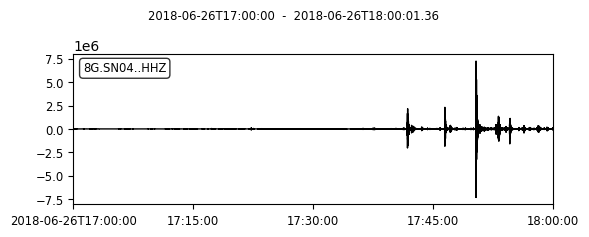

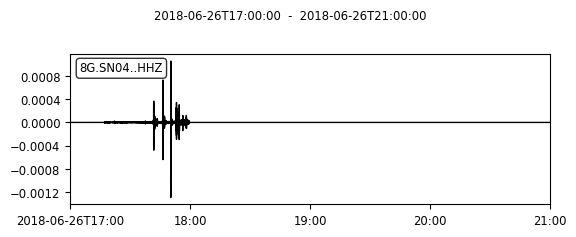

In [10]:
# Get a file to read
filepath_raw = filepaths_raw[0]
filename_raw = os.path.basename(filepath_raw)
filepath_processed = os.path.join(DIRPATH_PROCESSED, filename_raw)

# Loop over cases and show
for filepath in (filepath_raw, filepath_processed):
    stream = obspy.read(filepath)
    stream.trim(endtime=t0+tdur)
    stream.plot(size=(600, 250))

# Next Part! Travel times
set up a velocity model

            P       S
depth                
-3.0   1.5500  0.7955
 0.0   1.9500  1.0955
 0.5   2.4556  1.3795
 1.0   2.9611  1.6635
 1.5   3.4667  1.9476
 2.0   3.9722  2.2316
 2.5   4.4778  2.5156
 3.0   4.9833  2.7996
 3.5   5.4889  3.0836
 4.0   5.9944  3.3677
 4.5   6.5000  3.6517
 5.0   6.5273  3.6670


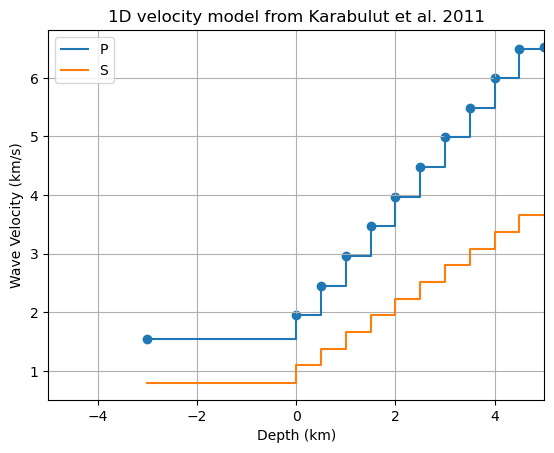

In [6]:
FILEPATH_VELOCITY = '/Users/brendanmills/Documents/Senior_Thesis/PdFTestRun/jgrb50189-sup-0003-vmodel1d'
# Read velocity model
velocity_layers = pd.read_csv(
    FILEPATH_VELOCITY, 
    names=["depth", "P", "S"],
    index_col="depth",
    )

# Show table
print(velocity_layers)

ax = velocity_layers.plot(
    drawstyle="steps-post",
    ylabel="Wave Velocity (km/s)",
    xlabel="Depth (km)",
    title="1D velocity model from Karabulut et al. 2011",
    grid=True,
    xlim=(-5,5)
)
plt.scatter(velocity_layers.index, velocity_layers.loc[:,'P'])

Interpolate for depths

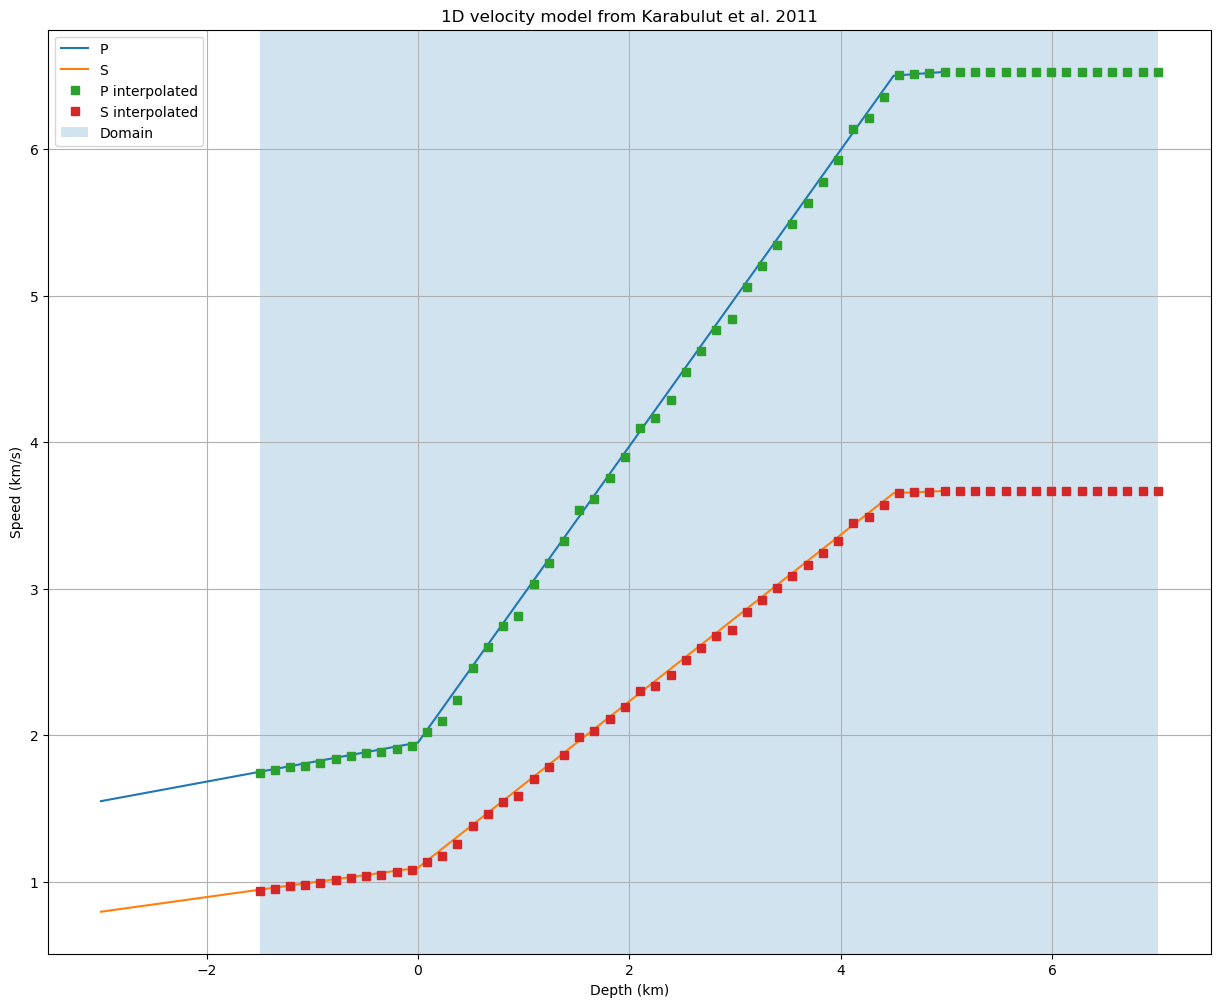

In [27]:
#OK I know this is code soup
interp_depths = np.linspace(np.amin(velocity_layers.index), np.amax(velocity_layers.index), 100)
#this smashes the arrays together
interp_depths = np.sort(np.concatenate((interp_depths,np.array(velocity_layers.index)),axis=None))
#This removes duplicates at the ends
interp_depths = interp_depths[1:-1]

velocity_layers_interp = velocity_layers.reindex(interp_depths)
velocity_layers_interp = velocity_layers_interp.interpolate()

depth_min = -1.5  # edifice summit (km)
depth_max = 7  # max depth of traveltime grids (km)
depths = np.linspace(depth_max, depth_min, 60)
velocity_layers_interp = velocity_layers_interp.reindex(depths,method='ffill')

velocity_layers.plot()
velocity_layers_interp.plot(
    drawstyle="steps-post",
    xlabel="Depth (km)",
    ylabel="Speed (km/s)",
    title="1D velocity model from Karabulut et al. 2011",
    ax=plt.gca(),
    grid=True,
    figsize=(15, 12),
    marker="s",
    ls=""
)

# Labels and legends
plt.axvspan(depths.min(), depths.max(), alpha=0.2)
plt.legend(["P", "S", "P interpolated", "S interpolated", "Domain"])
plt.show()

## Expand model laterally

Because `pykonal` uses three-dimensional coordinate systems, we need to cast the one-dimensional velocity model onto a three-dimensional grid. The following define the grid in the longitude and latitude dimensions.

In [22]:
longitudes = np.linspace(domain.minlongitude, domain.maxlongitude, 150)
# sample latitudes in decreasing order to get corresponding colatitudes in increasing order (see explanation further)
latitudes = np.linspace(domain.minlatitude, domain.maxlatitude, 150)
# Xarray
velocities = velocity_layers_interp.stack().to_xarray()
velocities = velocities.rename({"level_1": "phase"})

# Add longitudes and latitude dimensions (automatically broadcast vector into 3D array)
velocities = velocities.expand_dims(latitude=latitudes, longitude=longitudes)

## Station coordinates

We extract the station coordinates from the XML files.

In [23]:
# Get inventories
inventory = read_inventory(DIRPATH_PROCESSED + '*xml')

# Extract stations
stations = [sta for net in inventory for sta in net]
attrs = "longitude", "latitude", "elevation", "code"
stations = [{item: getattr(sta, item) for item in attrs} for sta in stations]

# Turn into dataframe
network = pd.DataFrame(stations).set_index("code")
network["depth"] = -1e-3 * network.elevation 

# Show
network


,longitude,latitude,elevation,depth
code,,,,
SN04,-91.129210,-0.850070,1073.0,-1.073
SN05,-91.147560,-0.851940,1045.0,-1.045
SN07,-91.170050,-0.807190,1067.0,-1.067
SN11,-91.123990,-0.802000,935.0,-0.935
SN12,-91.134960,-0.811195,957.0,-0.957
SN13,-91.074890,-0.619690,10.0,-0.010
SN14,-91.152610,-0.843680,913.0,-0.913
SN06,-91.168556,-0.839140,1008.0,-1.008


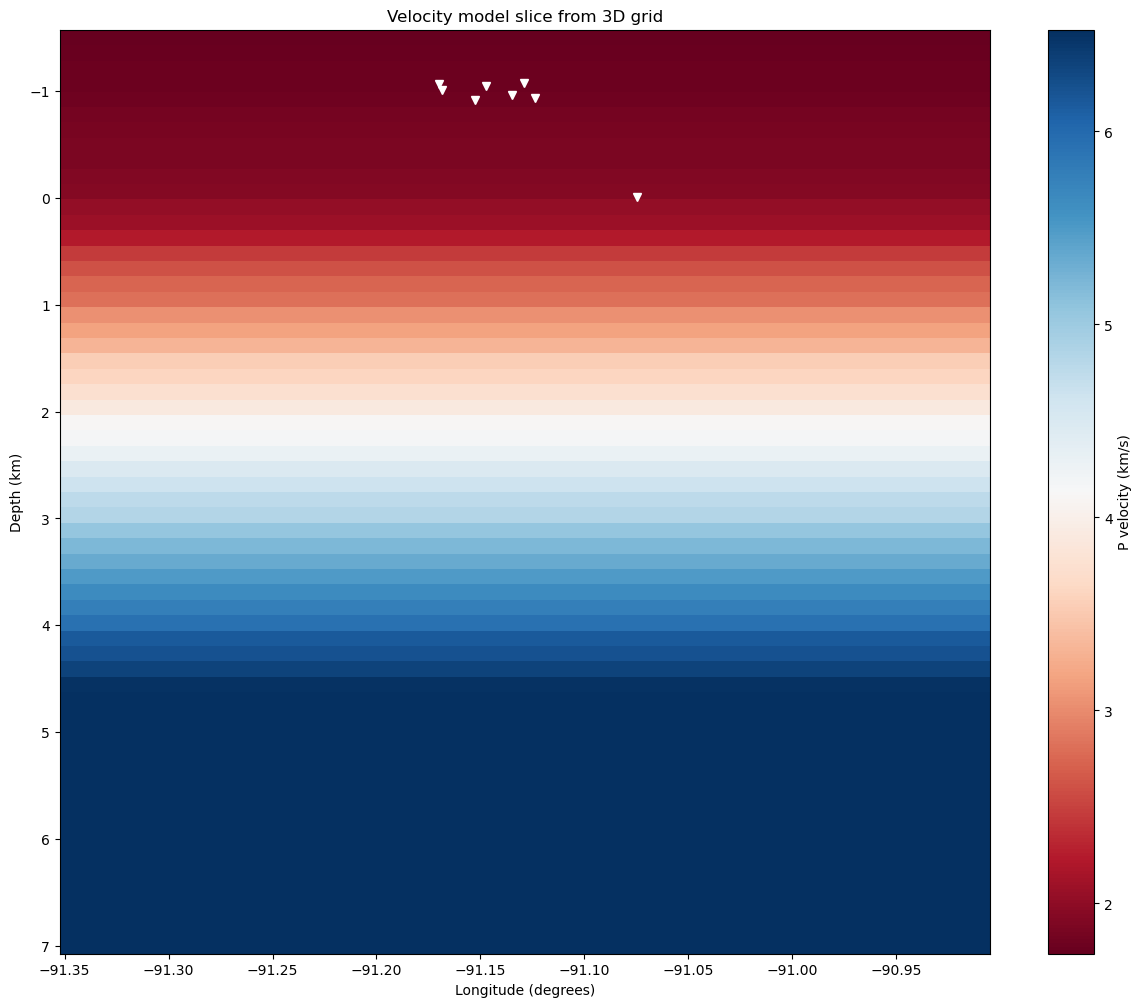

In [24]:
# Select slice at first latitude index
velocities_slice = velocities.sel(phase="P", latitude=latitudes.min())

# Show velocities
img = velocities_slice.T.plot.imshow(cmap="RdBu", add_colorbar=False, figsize=(15, 12))
cb = plt.colorbar(img)

# Show stations
plt.plot(network.longitude, network.depth, "wv")

# Labels
ax = plt.gca()
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_title("Velocity model slice from 3D grid")
cb.set_label(f"{velocities_slice.phase.data} velocity (km/s)")
ax.invert_yaxis()

## Compute travel times

The travel times are computed for every station with the Eikonal solver of `pykonal`. The travel times are then saved into a `h5` file for later use. 

**Warning**: For `pykonal`, we need to give the velocity grid in spherical coordinates $(r, \theta, \varphi)$, which is why we built the grid with decreasing depths and latitudes.

Spherical coordinates:
- $r$: Distance from center or Earth in km (= decreasing depth).
- $\theta$: Polar angle in radians (= co-latitude or, equivalently, decreasing latitude).
- $\varphi$: Azimuthal angle in radians (= longitude).

In [25]:
STATION_ENTRIES = ["latitude", "longitude", "depth"]

# Initialize travel times
velocities_solver = velocities.transpose("phase", "depth", "latitude", "longitude")
travel_times = velocities_solver.copy()
travel_times = travel_times.expand_dims(station=network.index.values).copy()

# Reference point
reference_point = geo2sph((latitudes.max(), longitudes.min(), depths.max()))
node_intervals = (
    np.abs(depths[1] - depths[0]),
    np.deg2rad(np.abs(latitudes[1] - latitudes[0])),
    np.deg2rad(longitudes[1] - longitudes[0]),
)

# Loop over stations and phases
for phase in travel_times.phase.data:
    for station in tqdm.tqdm(network.index, desc=f"Travel times {phase}"):

        # Initialize Eikonal solver
        solver = PointSourceSolver(coord_sys="spherical")
        solver.velocity.min_coords = reference_point
        solver.velocity.node_intervals = node_intervals
        velocity = velocities_solver.sel(phase=phase).to_numpy()
        solver.velocity.npts = velocity.shape
        solver.velocity.values = velocity.copy()
        
        # Source
        src_loc = network.loc[station][STATION_ENTRIES].values
        solver.src_loc = np.array(geo2sph(src_loc).squeeze())

        # Solve Eikonal equation
        solver.solve()

        # Assign to dataarray
        locator = dict(station=station, phase=phase)
        tt = solver.tt.values
        tt[np.isinf(tt)] = 0
        travel_times.loc[locator] = tt

Travel times S: 100%|█████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


In [17]:
#saves the whole database to the traveltimes

TTIMES_PATH = PROJECT_PATH + 'TTimes/'
os.makedirs(TTIMES_PATH, exist_ok=True)
travel_times.to_netcdf(TTIMES_PATH + 'travel_times.nc')

In [18]:
# # clip the dem to the bounds using gdal
# dataset = gdal.Open('/Users/brendanmills/Documents/Senior_Thesis/GalapagosDEM/pdfclip.tif')

# # path to where you want the clipped raster
# outputSrtm = '/Users/brendanmills/Documents/Senior_Thesis/GalapagosDEM/pdfclipZoom.tif'
# gdal.Translate(outputSrtm , dataset,projWin = [lon_min, lat_max,lon_max, lat_min])

# # Download DEM and interpolate to grid
# dem_path = outputSrtm
# dem = rasterio.open(dem_path)  # open downloaded dem file
# dem1 = dem.read(1)  # extract values
# dem1 = np.where(dem1 == -32768, 0, dem1)  # replace null values with zero
# nx_dem = dem1.shape[0]  # x dimension of dem grid
# ny_dem = dem1.shape[1]  # y dimension of dem grid

# #this script places a high travel time on anything that is in the air
# for sta in network.index:
#     time_delays = travel_times.sel(phase=SEISMIC_PHASE, station=network.loc[sta].name)
#     for slabi in tqdm.tqdm(range(len(time_delays)),desc=f'Chopping for station {sta}'):
#         d = depths[slabi]
#         height = -1000*d
#         if height < 0:
#             continue
# #         print(height)
#         tds = time_delays[slabi]
#         for index, x in np.ndenumerate(tds):
#             fraci = index[0]/time_delays.shape[1]
#             fracj = index[1]/time_delays.shape[2]
# #             print('fracs',fraci,fracj)
#             demi = int(fraci*nx_dem)
#             demj = int(fracj*ny_dem)
# #             print('dem coord',demi, demj)
#             demh = dem1[demi,demj]
# #             print('heights',height, demh)
#             if height > demh:
#                 tds[index] = 100
# #                 print('override')


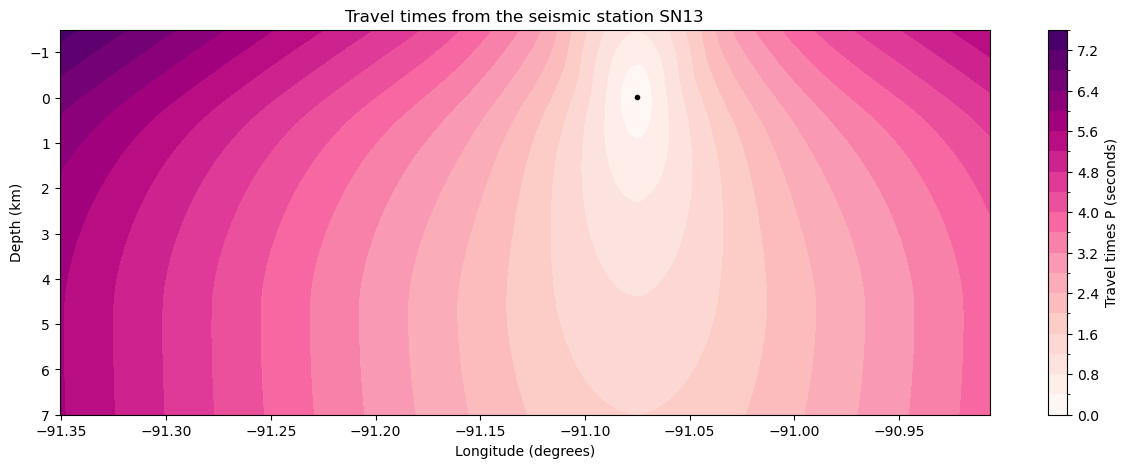

In [26]:
CONTOUR_LEVELS = 20
SEISMIC_PHASE = "P"
station = network.loc["SN13"]

# Show
latitude_id = np.abs(travel_times.latitude - station.latitude).argmin()
time_delays = travel_times.sel(phase=SEISMIC_PHASE, station=station.name)
time_delays = np.flip(time_delays, 1)
time_delays = time_delays.isel(latitude=latitude_id)
img = time_delays.plot.contourf(
    add_colorbar=False, cmap="RdPu", levels=CONTOUR_LEVELS, figsize=(15, 5)
)

# Colorbar
cb = plt.colorbar(img)
cb.set_label(f"Travel times {SEISMIC_PHASE} (seconds)")

# Station
plt.plot(station.longitude, station.depth, "k.")

# Labels
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_title(f"Travel times from the seismic station {station.name}")
plt.show()

This next one goes through all the stations and saves them as npys

In [20]:
for s in list(network.index):
    tt = travel_times.sel(station=s,phase='P').T#I added the Transpose here, not sure if it is right
    nptt = tt.to_numpy()
    np.save(TTIMES_PATH  + f'{s}.npy',nptt)


Ok so that should have generated all the tt files I need to continue with the covariance stuff

In [21]:
client = Client("IRIS")
stream = csn.arraystream.ArrayStream()
for filepath_waveform in tqdm.tqdm(filepaths_raw, desc="Collecting Streams"):
    st = obspy.read(filepath_waveform)
    stream.append(st[0]) 

# decimate data to 20Hz
stream.decimate(5)

# download metadata
inv = client.get_stations(
    network="8G", location="*", channel="*HZ", starttime=t0, endtime=t0 + tdur
)

In [22]:
traveltime_filepath = TTIMES_PATH  # path to traveltime grids
# frequency limits for filtering (depends on the target signal)
low_pass = 0.5
high_pass = 10.0

# optimized for VT earthquakes
# window_duration_sec = 12
# average = 20

# optimized for tremors
window_duration_sec = 5*60
average = 30

overlap = 0.5
sampling_rate = stream[0].stats.sampling_rate  # assumes all streams have the same sampling rate
preproc_spectral_secs = window_duration_sec * average * overlap
sigma = 20  # Correlation Smoothing

i_win = 5  # choose the 5th window for plotting likelihood

In [23]:
## merge traces to have one trace per station
stream.merge(method=1, fill_value="interpolate", interpolation_samples=-1)

## synchronize traces in the stream
stream = stream.synchronize(t0, tdur, method="linear")

## filtering
stream.detrend(type="demean")
stream.detrend(type="linear")
stream.filter(type="bandpass", freqmin=low_pass, freqmax=high_pass)

# choose waveform from channel HHZ of station OGDF for plotting
trace_plot = stream.select(station="SN07", channel="HHZ")[0].data

/opt/anaconda3/envs/obspy39/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (10.0) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


In [24]:
## Preprocess
stream.preprocess(
    domain="spectral", method="onebit", window_duration_sec=preproc_spectral_secs
)
stream.trim(t0, t0 + tdur)  # preprocessing can add artifacts to ends


7 Trace(s) in Stream:
8G.SN04..HHZ | 2018-06-26T17:00:00.000000Z - 2018-06-26T21:00:00.000000Z | 20.0 Hz, 288001 samples
8G.SN05..HHZ | 2018-06-26T17:00:00.000000Z - 2018-06-26T21:00:00.000000Z | 20.0 Hz, 288001 samples
8G.SN07..HHZ | 2018-06-26T17:00:00.000000Z - 2018-06-26T21:00:00.000000Z | 20.0 Hz, 288001 samples
8G.SN11..HHZ | 2018-06-26T17:00:00.000000Z - 2018-06-26T21:00:00.000000Z | 20.0 Hz, 288001 samples
8G.SN12..HHZ | 2018-06-26T17:00:00.000000Z - 2018-06-26T21:00:00.000000Z | 20.0 Hz, 288001 samples
8G.SN13..HHZ | 2018-06-26T17:00:00.000000Z - 2018-06-26T21:00:00.000000Z | 20.0 Hz, 288001 samples
8G.SN14..HHZ | 2018-06-26T17:00:00.000000Z - 2018-06-26T21:00:00.000000Z | 20.0 Hz, 288001 samples

In [25]:
# Calculate coherence
# -------------------

times, frequencies, covariances = csn.covariancematrix.calculate(
    stream, window_duration_sec, average
)


# Spectral width
spectral_width = covariances.coherence(kind="spectral_width")

# Average spectral width between 0.5Hz and 5Hz
i_freq_low = round(0.5 * spectral_width.shape[1] / sampling_rate)
i_freq_high = round(5 * spectral_width.shape[1] / sampling_rate)
spectral_width_average = np.mean(spectral_width[:, i_freq_low:i_freq_high], axis=1)

# Eigenvector decomposition - covariance matrix filtered by the 1st eigenvector to show the dominant source
covariance_1st = covariances.eigenvectors(covariance=True, rank=0)

# Extract cross-correlations
lags, correlation = csn.correlationmatrix.cross_correlation(
    covariance_1st, sampling_rate
)

Moment of truth

In [26]:
# load traveltime grids from file
PdF_traveltimes = csn.traveltime.TravelTime(stream, traveltime_filepath)

Ok that is good that means that it loaded the travel times somewhat successfully

In [27]:
# Initiate beam object and set geographical extent of grid
nwin = correlation.nwin()  # number of time windows
PdF_beam = csn.beam.Beam(nwin, PdF_traveltimes)
PdF_beam.set_extent(lon_min, lon_max, lat_min, lat_max, depth_min, depth_max)

In [28]:
# Loop through all windows and calculate likelihood and nrf
for i in range(0, nwin):
    print("Processing window", i + 1, "of", nwin)

    correl = correlation[i]

    # Filter correlation
    correl = correl.bandpass(low_pass, high_pass, sampling_rate)

    # Smooth correlation
    correl = correl.hilbert_envelope()
    correl = correl.smooth(sigma=sigma)  # default sigma is 5

    PdF_beam.calculate_likelihood(correl, sampling_rate, i)
    PdF_beam.calculate_nrf(i)

    beam_max = PdF_beam.max_likelihood(i)
    print(
        "Maximum likelihood at",
        round(beam_max[0], 4),
        "\N{DEGREE SIGN},",
        round(beam_max[1], 4),
        "\N{DEGREE SIGN},",
        round(beam_max[2], 1),
        "km",
    )

Processing window 1 of 5
Maximum likelihood at -91.1554 °, -0.7617 °, 4.9 km
Processing window 2 of 5
Maximum likelihood at -91.1583 °, -0.7617 °, 4.9 km
Processing window 3 of 5
Maximum likelihood at -91.1583 °, -0.7645 °, 4.9 km
Processing window 4 of 5
Maximum likelihood at -91.1642 °, -0.7589 °, 4.9 km
Processing window 5 of 5
Maximum likelihood at -91.1642 °, -0.7589 °, 4.9 km


Text(0.5, 0, 'Minutes')

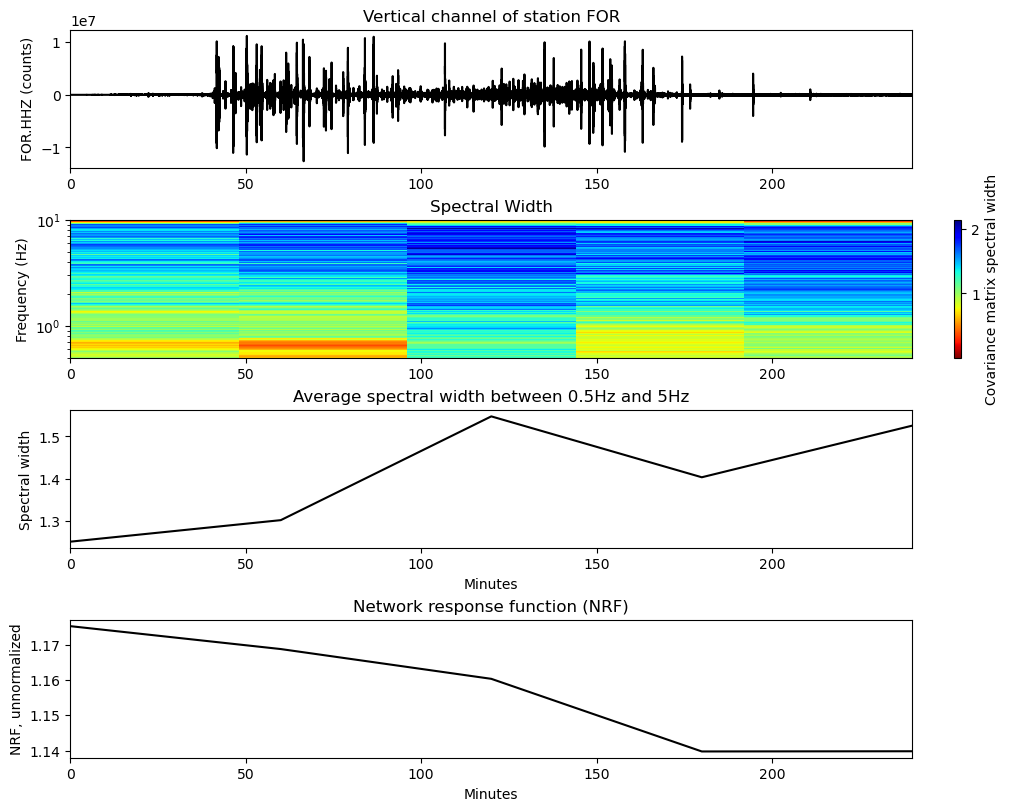

In [29]:
# # plot nrf and spectral width and waveforms from closest station
duration_min = tdur / 60
fig, ax = plt.subplots(4, constrained_layout=True, figsize=(10, 8))  # stretched plot

ax[0].plot(np.linspace(0, duration_min, len(trace_plot)), trace_plot, "k")
ax[0].set_title("Vertical channel of station FOR")
ax[0].set_ylabel("FOR.HHZ (counts)")
ax[0].set_xlim([0, duration_min])

img = ax[1].imshow(
    spectral_width.T,
    origin="lower",
    cmap="jet_r",
    interpolation="none",
    extent=[0, tdur / 60, 0, sampling_rate],
    aspect="auto",
)
ax[1].set_ylim(
    [0.5, stream[0].stats.sampling_rate / 2]
)  # hide microseismic background noise below 0.5Hz
ax[1].set_ylabel("Frequency (Hz)")
ax[1].set_yscale("log")
ax[1].set_title("Spectral Width")
plt.colorbar(img, ax=ax[1]).set_label("Covariance matrix spectral width")

ax[2].plot(np.linspace(0, duration_min, nwin), spectral_width_average, "k")
ax[2].set_title("Average spectral width between 0.5Hz and 5Hz")
ax[2].set_ylabel("Spectral width")
ax[2].set_xlim(0, duration_min)
ax[2].set_xlabel("Minutes")

ax[3].plot(np.linspace(0, duration_min, nwin), PdF_beam.nrf, "k")
ax[3].set_title("Network response function (NRF)")
ax[3].set_ylabel("NRF, unnormalized")
ax[3].set_xlim(0, duration_min)
ax[3].set_xlabel("Minutes")

In [30]:
i_win = 4
# extract max likelihood position
beam_max = PdF_beam.max_likelihood(i_win)
x_max = beam_max[0]
y_max = beam_max[1]
z_max = beam_max[2]

# Choose the last window for plotting likelihood
likelihood_xyz = PdF_beam.likelihood[i_win, :, :, :]

# Take slices at point of max likelihood
i_max, j_max, k_max = np.unravel_index(likelihood_xyz.argmax(), likelihood_xyz.shape)
likelihood_xy = likelihood_xyz[:, :, k_max]
# print(likelihood_xy.shape)
likelihood_xz = likelihood_xyz[:, j_max]
likelihood_yz = likelihood_xyz[i_max]

# Normalize likelihood between 0 and 1
likelihood_xy = (likelihood_xy - likelihood_xy.min()) / (
    likelihood_xy.max() - likelihood_xy.min()
)
likelihood_xz = (likelihood_xz - likelihood_xz.min()) / (
    likelihood_xz.max() - likelihood_xz.min()
)
likelihood_yz = (likelihood_yz - likelihood_yz.min()) / (
    likelihood_yz.max() - likelihood_yz.min()
)

In [31]:
# clip the dem to the bounds using gdal
dataset = gdal.Open('/Users/brendanmills/Documents/Senior_Thesis/GalapagosDEM/GalDEMclip.tif')

# path to where you want the clipped raster
outputSrtm = '/Users/brendanmills/Documents/Senior_Thesis/GalapagosDEM/GalDEMclipzoom.tif'
gdal.Translate(outputSrtm , dataset,projWin = [lon_min, lat_max, lon_max, lat_min])

# Download DEM and interpolate to grid
dem_path = outputSrtm
dem = rasterio.open(dem_path)  # open downloaded dem file
dem1 = dem.read(1)  # extract values
dem1 = np.where(dem1 == -999, 0, dem1)  # replace null values with zero
nx_dem = dem1.shape[0]  # x dimension of dem grid
ny_dem = dem1.shape[1]  # y dimension of dem grid
# old dem grid
x,y = np.mgrid[0 : nx_dem - 1 : complex(nx_dem), 0 : ny_dem - 1 : complex(ny_dem)]
# new dem grid, with dimensions matching our traveltime grid
x2, y2 = np.mgrid[
    0 : nx_dem - 1 : complex(PdF_traveltimes.nx),
    0 : ny_dem - 1 : complex(PdF_traveltimes.ny),
]
# interpolate onto the new grid
dem2 = scipy.interpolate.griddata(
    (x.ravel(),y.ravel()), dem1.ravel(), (x2, y2), method="linear"
)
dem_x = -1 * dem2[i_max, :] / 1000  # dem along xz slice, convert to km
dem_y = np.flip(-1 * dem2[:, j_max] / 1000)  # dem along yz slice, convert to km

In [32]:
# create dictionary of station metadata from station xml
net = {"lat": [], "lon": []}
for tr in stream:
    inv_sel = inv.select(station=tr.stats.station)
    net["lat"].append(inv_sel[0][0].latitude)
    net["lon"].append(inv_sel[0][0].longitude)

# create custom discrete colormap for likelihood
low = 4
levels = 12
n_colours = 16  # number of discrete colours to split colourbar into
custom_cmap = plt.cm.get_cmap("RdYlBu_r")(np.linspace(0, 1, levels))
for i in range(low):
    custom_cmap[i, :] = [1, 1, 1, 1]
for i in range(1, levels):
    custom_cmap[i, -1] = np.sqrt(i / levels)
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "RdYlBu_r", custom_cmap, N=n_colours
)

# create custome discrete colormap for topography
levels = 12
custom_cmap_dem = plt.cm.get_cmap("Greys")(np.linspace(0.2, 0.5, levels))
custom_cmap_dem = mcolors.LinearSegmentedColormap.from_list("Greys", custom_cmap_dem)

# prepare shaded topography
# create light source object.
ls = LightSource(azdeg=315, altdeg=45)
# shade data, creating an rgb array.
rgb = ls.shade(dem2, custom_cmap_dem)

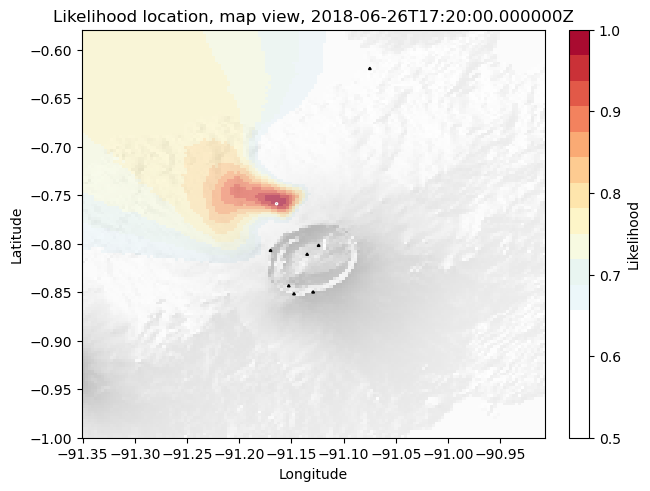

In [33]:
# plot map view
fig, ax = plt.subplots(1, constrained_layout=True, dpi=100)
img_xy = ax.imshow(
    likelihood_xy.T,
    interpolation="none",
    origin="lower",
    cmap=custom_cmap,
    aspect="auto",
    extent=[lon_min, lon_max, lat_min, lat_max],
    vmin=0.5,
)
img_xy_dem = ax.imshow(
    rgb,
    interpolation="none",
    alpha=0.35,
    cmap=plt.get_cmap("Greys"),
    aspect="auto",
    extent=[lon_min, lon_max, lat_min, lat_max],
)
ax.add_patch(
    plt.Circle((x_max, y_max), facecolor="black", edgecolor="white", radius=0.001)
)  # plot max likelihood position
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
itime = t0 + i_win * window_duration_sec
ax.set_title(f"Likelihood location, map view, {itime}")
plt.savefig(f'/Users/brendanmills/Documents/Senior_Thesis/Figs/Localization/Model2/SNi{i_win}')
for x, y in zip(net["lon"], net["lat"]):  # plot stations
    triangle = RegularPolygon(
        (x, y), facecolor="white", edgecolor="black", numVertices=3, radius=0.0015
    )
    ax.add_patch(triangle)
plt.colorbar(img_xy).set_label("Likelihood")

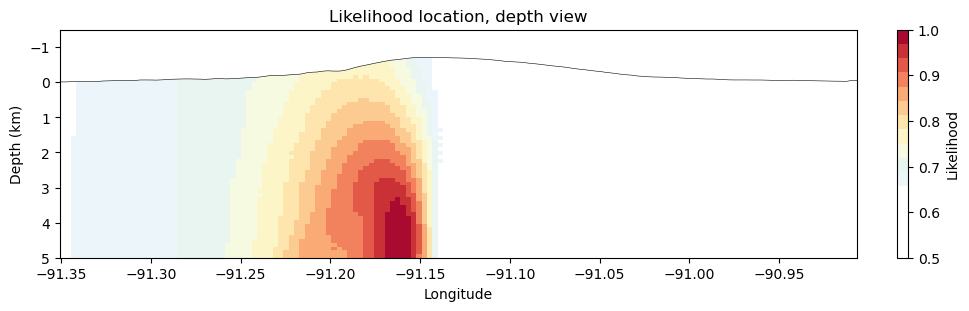

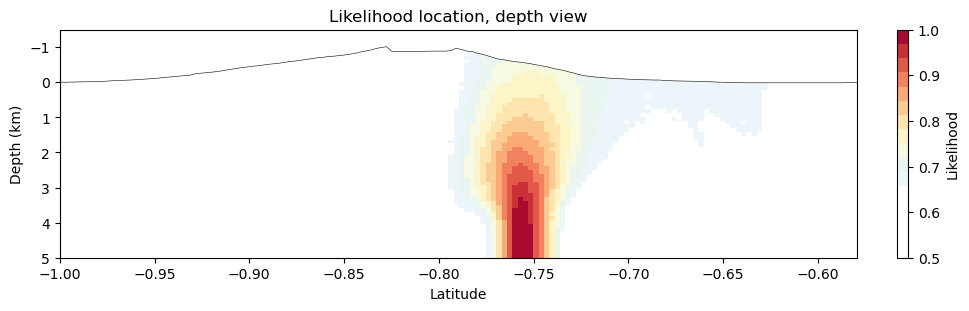

In [34]:
# plot depth views
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(9.6, 3), dpi=100)
img_xz = ax.imshow(
    likelihood_xz.T,
    interpolation="none",
    origin="upper",
    cmap=custom_cmap,
    aspect="auto",
    extent=[lon_min, lon_max, depth_max, depth_min],
    vmin=0.5,
)
ax.fill_between(
    np.linspace(lon_min, lon_max, len(dem_x)),
    depth_min,
    dem_x,
    facecolor="w",
    edgecolor="k",
    lw=0.4,
)  # crop out data above topo
ax.set_xlabel("Longitude")
ax.set_ylabel("Depth (km)")
ax.set_title("Likelihood location, depth view")
plt.colorbar(img_xz).set_label("Likelihood")

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(9.6, 3), dpi=100)
img_yz = ax.imshow(
    likelihood_yz.T,
    interpolation="none",
    origin="upper",
    cmap=custom_cmap,
    aspect="auto",
    extent=[lat_min, lat_max, depth_max, depth_min],
    vmin=0.5,
)
ax.fill_between(
    np.linspace(lat_min, lat_max, len(dem_y)),
    depth_min,
    dem_y,
    facecolor="w",
    edgecolor="k",
    lw=0.4,
)  # crop out data above topo
ax.set_xlabel("Latitude")
ax.set_ylabel("Depth (km)")
ax.set_title("Likelihood location, depth view")
plt.colorbar(img_yz).set_label("Likelihood")

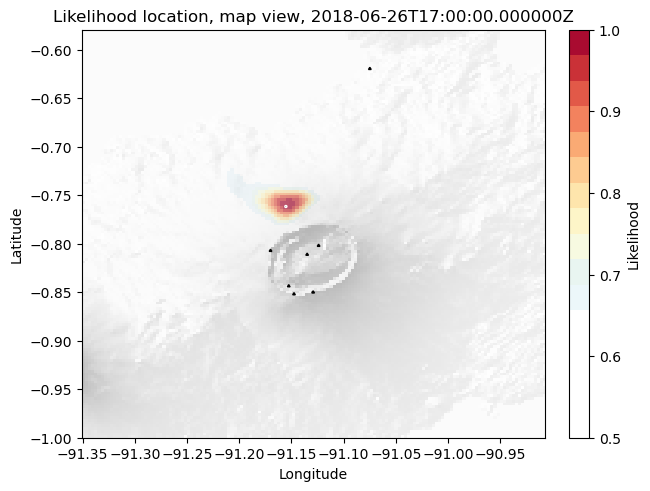

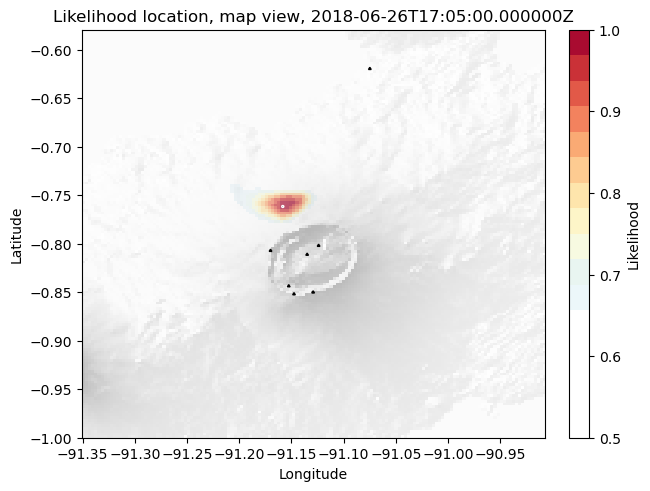

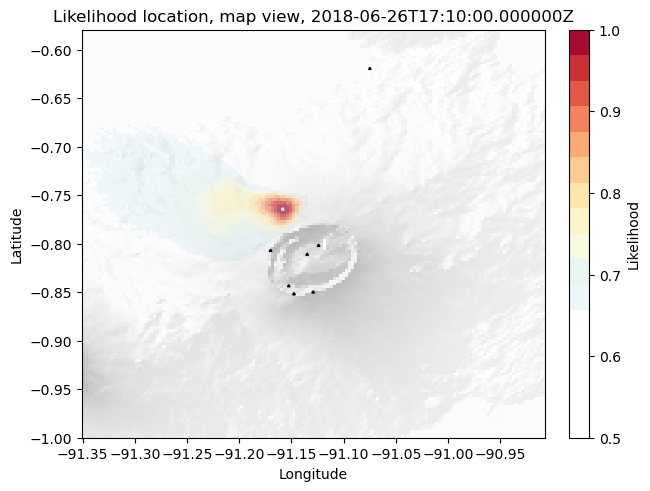

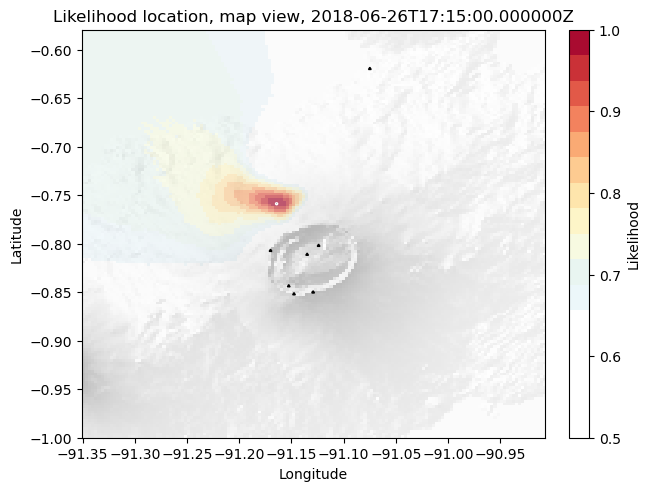

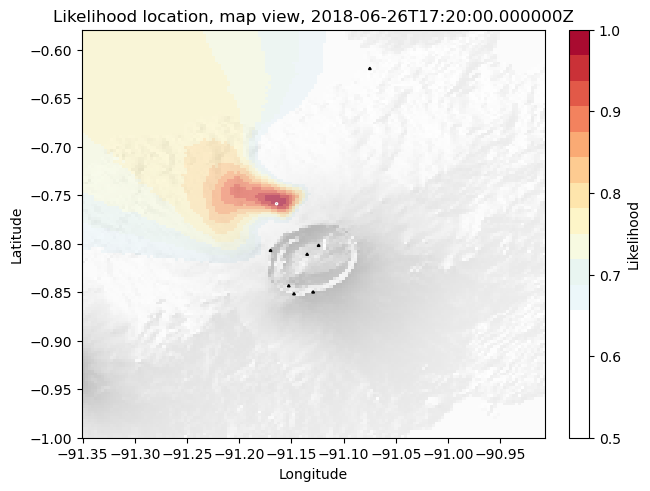

In [35]:
# clip the dem to the bounds using gdal
dataset = gdal.Open('/Users/brendanmills/Documents/Senior_Thesis/GalapagosDEM/GalDEMclip.tif')

# path to where you want the clipped raster
outputSrtm = '/Users/brendanmills/Documents/Senior_Thesis/GalapagosDEM/GalDEMclipzoom.tif'
gdal.Translate(outputSrtm , dataset,projWin = [lon_min, lat_max, lon_max, lat_min])

# Download DEM and interpolate to grid
dem_path = outputSrtm
dem = rasterio.open(dem_path)  # open downloaded dem file
dem1 = dem.read(1)  # extract values
dem1 = np.where(dem1 == -999, 0, dem1)  # replace null values with zero
nx_dem = dem1.shape[0]  # x dimension of dem grid
ny_dem = dem1.shape[1]  # y dimension of dem grid
# old dem grid
x,y = np.mgrid[0 : nx_dem - 1 : complex(nx_dem), 0 : ny_dem - 1 : complex(ny_dem)]
# new dem grid, with dimensions matching our traveltime grid
x2, y2 = np.mgrid[
    0 : nx_dem - 1 : complex(PdF_traveltimes.nx),
    0 : ny_dem - 1 : complex(PdF_traveltimes.ny),
]
# interpolate onto the new grid
dem2 = scipy.interpolate.griddata(
    (x.ravel(),y.ravel()), dem1.ravel(), (x2, y2), method="linear"
)
dem_x = -1 * dem2[i_max, :] / 1000  # dem along xz slice, convert to km
dem_y = np.flip(-1 * dem2[:, j_max] / 1000)  # dem along yz slice, convert to km
# create dictionary of station metadata from station xml
net = {"lat": [], "lon": []}
for tr in stream:
    inv_sel = inv.select(station=tr.stats.station)
    net["lat"].append(inv_sel[0][0].latitude)
    net["lon"].append(inv_sel[0][0].longitude)

# create custom discrete colormap for likelihood
low = 4
levels = 12
n_colours = 16  # number of discrete colours to split colourbar into
custom_cmap = plt.cm.get_cmap("RdYlBu_r")(np.linspace(0, 1, levels))
for i in range(low):
    custom_cmap[i, :] = [1, 1, 1, 1]
for i in range(1, levels):
    custom_cmap[i, -1] = np.sqrt(i / levels)
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "RdYlBu_r", custom_cmap, N=n_colours
)

# create custome discrete colormap for topography
levels = 12
custom_cmap_dem = plt.cm.get_cmap("Greys")(np.linspace(0.2, 0.5, levels))
custom_cmap_dem = mcolors.LinearSegmentedColormap.from_list("Greys", custom_cmap_dem)

# prepare shaded topography
# create light source object.
ls = LightSource(azdeg=315, altdeg=45)
# shade data, creating an rgb array.
rgb = ls.shade(dem2, custom_cmap_dem)

def window_bunch(inds, model_num):
    '''THis is just supposed to be an amalgamation of what has already happened and so we can quickly 
    save figures in time. It uses all local variables'''
    for i_win in inds:
        # extract max likelihood position
        beam_max = PdF_beam.max_likelihood(i_win)
        x_max = beam_max[0]
        y_max = beam_max[1]
        z_max = beam_max[2]

        # Choose the last window for plotting likelihood
        likelihood_xyz = PdF_beam.likelihood[i_win, :, :, :]

        # Take slices at point of max likelihood
        i_max, j_max, k_max = np.unravel_index(likelihood_xyz.argmax(), likelihood_xyz.shape)
        likelihood_xy = likelihood_xyz[:, :, k_max]
        likelihood_xz = likelihood_xyz[:, j_max]
        likelihood_yz = likelihood_xyz[i_max]

        # Normalize likelihood between 0 and 1
        likelihood_xy = (likelihood_xy - likelihood_xy.min()) / ( likelihood_xy.max() - likelihood_xy.min() )
        likelihood_xz = (likelihood_xz - likelihood_xz.min()) / ( likelihood_xz.max() - likelihood_xz.min() )
        likelihood_yz = (likelihood_yz - likelihood_yz.min()) / ( likelihood_yz.max() - likelihood_yz.min() )
        # plot map view
        fig, ax = plt.subplots(1, constrained_layout=True, dpi=100)
        img_xy = ax.imshow(
            likelihood_xy.T,
            interpolation="none",
            origin="lower",
            cmap=custom_cmap,
            aspect="auto",
            extent=[lon_min, lon_max, lat_min, lat_max],
            vmin=0.5,
        )
        img_xy_dem = ax.imshow(
            rgb,
            interpolation="none",
            alpha=0.35,
            cmap=plt.get_cmap("Greys"),
            aspect="auto",
            extent=[lon_min, lon_max, lat_min, lat_max],
        )
        ax.add_patch(
            plt.Circle((x_max, y_max), facecolor="black", edgecolor="white", radius=0.001)
        )  # plot max likelihood position
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        itime = t0 + i_win * window_duration_sec
        ax.set_title(f"Likelihood location, map view, {itime}")
        file_out = f'/Users/brendanmills/Documents/Senior_Thesis/Figs/Localization/Model{model_num}/'
        os.makedirs(file_out, exist_ok=True)
        plt.savefig(file_out + f'SNi{i_win}')
        for x, y in zip(net["lon"], net["lat"]):  # plot stations
            triangle = RegularPolygon(
                (x, y), facecolor="white", edgecolor="black", numVertices=3, radius=0.0015
            )
            ax.add_patch(triangle)
        plt.colorbar(img_xy).set_label("Likelihood")
window_bunch(range(nwin),6)

In [36]:
t0 + i_win * window_duration_sec

2018-06-26T17:20:00.000000Z

In [37]:
print(nwin)

5


In [38]:
st[0].stats

         network: 8G
         station: SN14
        location: 
         channel: HHZ
       starttime: 2018-06-27T04:00:00.290000Z
         endtime: 2018-06-27T04:59:59.990000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 71995
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 1274, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 652288})
      processing: ["ObsPy 1.3.0: filter(options={'freq': 10.0, 'maxorder': 12}::type='lowpass_cheby_2')", 'ObsPy 1.3.0: decimate(factor=5::no_filter=False::strict_length=False)']